In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
from arcgis.gis import GIS
import pykrige.uk
from tqdm.notebook import tqdm
import datetime
from sklearn.linear_model import LinearRegression
import matplotlib
from scipy.spatial import cKDTree
from pygeostat.data import iotools

In [2]:
def ckdnearest(gdA, gdB):
    '''scipy's binary tree search for finding nearest neighbor points between two geodataframes'''
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

## Load Data

In [3]:
#well_measurements = pd.read_csv('./well_data/brewster_data.csv')
#well_measurements.info()

In [43]:
#well_measurements = pd.read_csv('./shallow_measurements_cvhm.csv', parse_dates=['MSMT_DATE'])
well_measurements = pd.read_csv('./shallow_measurements_all_cvhm.csv', parse_dates=['MSMT_DATE'])
site_points = [Point(xy) for xy in zip(well_measurements["LONGITUDE"], well_measurements["LATITUDE"])]
crs='epsg:4326'
well_measurements = gpd.GeoDataFrame(well_measurements, crs=crs, geometry=site_points)
#well_measurements = well_measurements.set_index(['MSMT_DATE'])
#well_measurements = well_measurements.sort_index(ascending=True)

/Users/mmorphew/opt/anaconda3/envs/research/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (29) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Filter Data by Date

In [79]:
mask = (well_measurements['MSMT_DATE'] > '2020-01-01') & (well_measurements['MSMT_DATE'] <= '2020-06-01')

In [80]:
timeframed_measurements = well_measurements.loc[mask]
#timeframed_measurements = well_measurements
timeframed_measurements = timeframed_measurements[timeframed_measurements['GSE_GWE'].notnull()]

In [81]:
print(timeframed_measurements.shape)

(1462, 51)


Taking only those points whose water surface elevation is lower than ground surface elevation.

In [137]:
#timeframed_measurements = timeframed_measurements[timeframed_measurements['GSE_WSE'] > 0]
timeframed_measurements = timeframed_measurements[timeframed_measurements['GSE_GWE'] > 0]
print(timeframed_measurements.columns)

Index(['Unnamed: 0', 'SITE_CODE', 'WLM_ID', 'MSMT_DATE', 'WLM_RPE', 'WLM_GSE',
       'GWE', 'GSE_GWE', 'WLM_QA_DESC', 'WLM_DESC', 'WLM_ACC_DESC',
       'WLM_ORG_NAME', 'COOP_ORG_NAME', 'MONITORING_PROGRAM', 'MSMT_CMT',
       'STN_ID', 'SWN', 'WELL_NAME', 'LATITUDE', 'LONGITUDE', 'GSE',
       'GSE_METHOD', 'GSE_ACC', 'BASIN_CODE', 'BASIN_NAME', 'COUNTY_NAME',
       'WELL_DEPTH', 'WELL_USE', 'WELL_TYPE', 'WCR_NO', 'TOP_PRF_INT_0',
       'BOT_PRF_INT_0', 'TOP_PRF_INT_1', 'BOT_PRF_INT_1', 'TOP_PRF_INT_2',
       'BOT_PRF_INT_2', 'TOP_PRF_INT_3', 'BOT_PRF_INT_3', 'TOP_PRF_INT_4',
       'BOT_PRF_INT_4', 'TOP_PRF_INT_5', 'BOT_PRF_INT_5', 'TOP_PRF_INT_6',
       'BOT_PRF_INT_6', 'TOP_PRF_INT_7', 'BOT_PRF_INT_7', 'TOP_PRF_INT_8',
       'BOT_PRF_INT_8', 'TOP_PRF_INT_9', 'BOT_PRF_INT_9', 'geometry'],
      dtype='object')


## Site filtering

In [87]:
timeframed_measurements['DROP'] = True

In [ ]:
site_codes = list(timeframed_measurements['SITE_CODE'].unique())
print(len(site_codes))
for site_code in site_codes:
    site_code_timeframed_measurements = timeframed_measurements[timeframed_measurements['SITE_CODE']==site_code]
    if len(site_code_timeframed_measurements) == 1:
        timeframed_measurements[timeframed_measurements['SITE_CODE']==site_code]['DROP'] = False
    else:
        site_code_timeframed_measurements["CLOSEST"] = abs(site_code_timeframed_measurements["MSMT_DATE"] - 
                                            datetime.datetime(2021, 3, 15))
        index_min = site_code_timeframed_measurements["CLOSEST"].idxmin()
        timeframed_measurements[timeframed_measurements['SITE_CODE']==site_code].loc[index_min, "DROP"] = False


In [ ]:
#timeframed_measurements.drop(timeframed_measurements.index[timeframed_measurements['DROP']==True], inplace=True)

## Extract X Y and Depth measurements + LVM (Locally Varying Mean) Trend Removal

In [89]:
timeframed_measurements_x = timeframed_measurements['LONGITUDE']
timeframed_measurements_y = timeframed_measurements['LATITUDE']
timeframed_measurements_z = timeframed_measurements['GSE_GWE']

In [90]:
#Y = shallow_measurements['GSE_GWE'].dropna().values
X = np.zeros((len(timeframed_measurements_x), 2))
X[:,0] = timeframed_measurements_x
X[:,1] = timeframed_measurements_y
Y = timeframed_measurements_z.copy()
# fit
reg = LinearRegression().fit(X, Y)

Text(0, 0.5, 'Prediction')

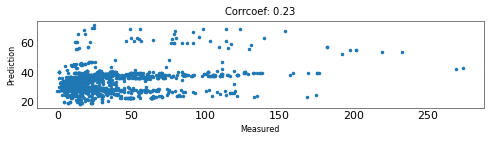

In [91]:
# compare the prediction and real porosity
matplotlib.rcParams.update({'font.size': 18})
plt.plot(Y, reg.predict(X),'.')
plt.title('Corrcoef: '+str(np.round(np.corrcoef([Y,reg.predict(X)])[0,1],2)))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Measured')
plt.ylabel('Prediction')

In [92]:
x_ = np.arange(-123, -118, 0.05)
y_ = np.arange(34.5, 41, 0.05)

xx,yy = np.meshgrid(x_,y_,indexing = 'ij')
xx = xx.reshape(-1)
yy = yy.reshape(-1)

# Predict
LVM = reg.predict(np.array([xx,yy]).T)
LVM = LVM.reshape(100,130)

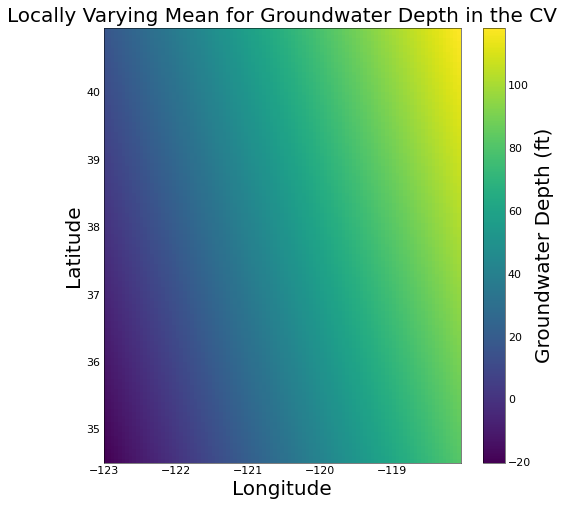

In [132]:
plt.pcolormesh(x_, y_, LVM.T)
plt.title("Locally Varying Mean for Groundwater Depth in the CV", fontsize=20)
plt.xlabel("Longitude", fontsize=20)
plt.ylabel("Latitude", fontsize=20)
plt.colorbar().set_label(label='Groundwater Depth (ft)',size=20)

In [94]:
LVM_site_points = [Point(xy) for xy in zip(xx, yy)]
LVM_sites = gpd.GeoDataFrame(LVM.reshape(-1), columns = ['LVM'], crs=crs, geometry=LVM_site_points)

In [95]:
print(timeframed_measurements.shape)
print(LVM.shape)

(1457, 51)
(100, 130)


In [96]:
timeframed_measurements_LVM = ckdnearest(timeframed_measurements, LVM_sites)

In [97]:
timeframed_measurements_LVM["GSE_GWE_NO_TREND"] = timeframed_measurements_LVM["GSE_GWE"] - timeframed_measurements_LVM["LVM"]

In [98]:
print(timeframed_measurements_LVM.shape)

(1457, 54)


In [99]:
#well_measurements_LVM.to_csv('shallow_measurements_timeframed_measurements_lvm_cvhm.csv')

In [100]:
#shallow_measurements_csv = iotools.read_csv('shallow_measurements_timeframed_measurements_lvm_cvhm.csv', headeronly=False, tmin=None)

In [101]:
#iotools.write_gslib(shallow_measurements_csv, 'shallow_measurements_all_cvhm_no_trend_gslib', variables=['LONGITUDE', 'LATITUDE', 'GSE_GWE_NO_TREND'])

In [138]:
timeframed_measurements_z_no_trend = timeframed_measurements_LVM["GSE_GWE_NO_TREND"]
timeframed_measurements_trend = timeframed_measurements_LVM["LVM"]
timeframed_measurements_x = timeframed_measurements_LVM["LONGITUDE"]
timeframed_measurements_y = timeframed_measurements_LVM["LATITUDE"]
timeframed_measurements_type = timeframed_measurements_LVM["WELL_TYPE"]

Stacking the x, y, and z data together in a new array

In [104]:
timeframed_measurements_xyz = np.vstack((timeframed_measurements_x, timeframed_measurements_y, timeframed_measurements_z_no_trend)).T
print(len(timeframed_measurements_xyz))

1457


## Bootstrap and Kriging

In [105]:
bootstrap_timeframed_measurements_xyz = np.zeros((100, len(timeframed_measurements_xyz), 3))
for i in range(len(bootstrap_timeframed_measurements_xyz)):
    bootstrap_indices = np.random.randint(len(timeframed_measurements_xyz), size=len(timeframed_measurements_xyz))
    bootstrap_timeframed_measurements_xyz[i] = timeframed_measurements_xyz[bootstrap_indices]
#for i in range(len(bootstrap_timeframed_measurements_xyz)):
#    boostrap_indices = np.random.choice(timeframed_measurements_xyz

In [106]:
#rows_to_delete = []
#for row_index in range(len(timeframed_measurements_xyz)-1):
#    if (timeframed_measurements_xyz[row_index,0] == timeframed_measurements_xyz[row_index+1,0] and
#        timeframed_measurements_xyz[row_index,1] == timeframed_measurements_xyz[row_index+1,1]):
#        rows_to_delete.append(row_index)
#timeframed_measurements_xyz = np.delete(timeframed_measurements_xyz, rows_to_delete, axis=0)

In [107]:
print(len(timeframed_measurements_xyz))
print(timeframed_measurements_xyz)

615
[[-119.359        35.3222       18.64098202]
 [-119.615        35.514       -42.73674578]
 [-119.618        35.5504      -44.02561044]
 ...
 [-122.539        40.48         47.11401237]
 [-122.243        40.4845       -8.33926463]
 [-122.239        40.5739       29.57187072]]


Create kriging grid (current resolution: 0.05 degrees)

In [108]:
gridx = np.arange(-123, -118, 0.05)
#gridx = np.arange(-122, -121, 0.05)
gridy = np.arange(34.5, 41, 0.05)
#gridy = np.arange(38.5, 39.5, 0.05)

meshgridx, meshgridy = np.meshgrid(gridx, gridy)

Set up bootstrap 

In [109]:
bootstrap_OK = []
for i in tqdm(range(len(bootstrap_timeframed_measurements_xyz))):
    bootstrap_OK.append(pykrige.ok.OrdinaryKriging(bootstrap_timeframed_measurements_xyz[i,:,0], 
                                    bootstrap_timeframed_measurements_xyz[i,:,1],
                                    bootstrap_timeframed_measurements_xyz[i,:,2], 
                                    variogram_model="spherical", variogram_parameters={
                                        "sill": 800, "nugget": 200, "range": 0.3
                                    }))

  0%|          | 0/100 [00:00<?, ?it/s]

In [110]:
bootstrap_z = []
bootstrap_ss = []
for i in tqdm(range(len(bootstrap_OK))):
    try:
        z, ss = bootstrap_OK[i].execute("grid", gridx, gridy)
        bootstrap_z.append(z)
        bootstrap_ss.append(ss)
    except:
        continue

  0%|          | 0/100 [00:00<?, ?it/s]

In [111]:
print(len(bootstrap_z))

100


## Plot Results

In [112]:
CA_map = gpd.read_file('Shapefiles/CA_State_TIGER2016.shp')
#CA_map.crs = 'epsg:4269'
#CA_map.to_crs(epsg='4326', inplace=True)
print(CA_map.crs)
CA_map.to_crs(epsg='4326', inplace=True)

CV_map = gpd.read_file('Shapefiles/Alluvial_Bnd.shp')
#CA_map.crs = 'epsg:4269'
#CA_map.to_crs(epsg='4326', inplace=True)
print(CV_map.crs)
CV_map.to_crs(epsg='4326', inplace=True)

PROJCS["WGS_1984_Web_Mercator_Auxiliary_Sphere",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4326"]],PROJECTION["Mercator_1SP"],PARAMETER["central_meridian",0],PARAMETER["scale_factor",1],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],EXTENSION["PROJ4","+proj=merc +a=6378137 +b=6378137 +lat_ts=0 +lon_0=0 +x_0=0 +y_0=0 +k=1 +units=m +nadgrids=@null +wktext +no_defs"]]
PROJCS["NAD_1983_Albers",GEOGCS["GCS_North_American_1983",DATUM["D_North_American_1983",SPHEROID["GRS_1980",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-120],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PAR

In [113]:
new_binary = mpl.colors.ListedColormap(np.array([[1., 1., 1., 1.],
       [0., 0., 0., 0.]]))
CV_overlay = np.zeros(meshgridx.shape)
CV_geom = CV_map['geometry'].values[0]
for i in tqdm(range(len(CV_overlay))):
    for j in range(len(CV_overlay[0,:])):
        potentialPoint = Point(meshgridx[i,j], meshgridy[i,j])
        if potentialPoint.within(CV_geom):
            CV_overlay[i,j] = 1

  0%|          | 0/130 [00:00<?, ?it/s]

In [114]:
z_mean = np.array(bootstrap_z)
print(z_mean.shape)
z_mean = np.mean(z_mean, axis=0)
print((z_mean+LVM.T).max())
print((z_mean+LVM.T).min())

(100, 130, 100)
188.1854475908002
-7.472497757403989


In [115]:
z_var = np.array(bootstrap_z)
z_var = np.sqrt(np.var(z_var, axis=0))
print(z_var.shape)

(130, 100)


Text(306.5740441012261, 0.5, 'Latitude')

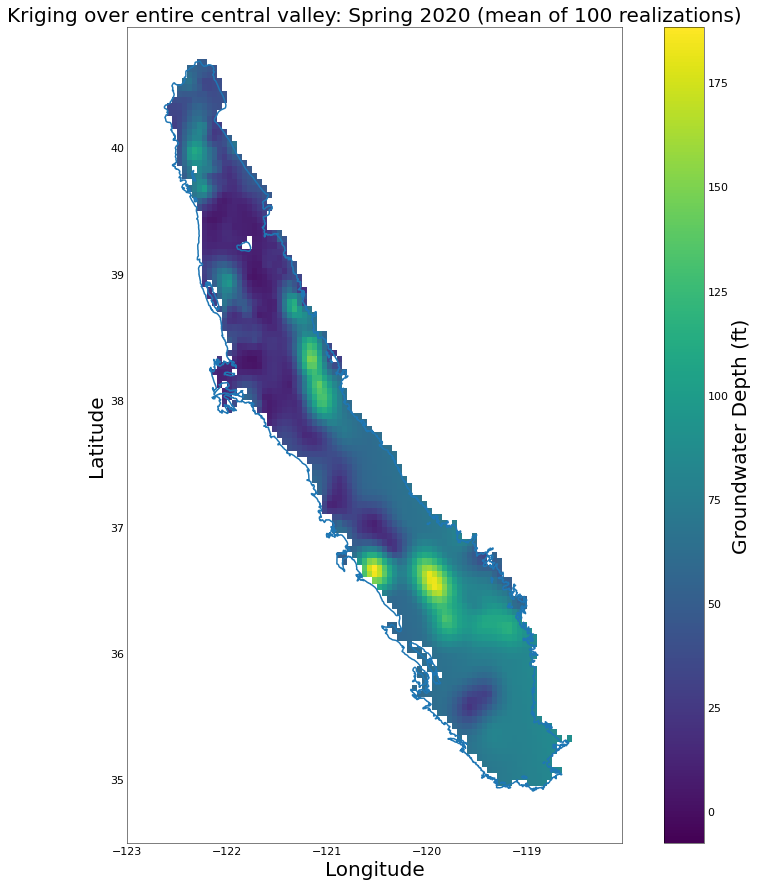

In [136]:
fig, ax = plt.subplots(figsize=(15,15))
#CA_map.boundary.plot(ax=ax, zorder=3)
CV_map.boundary.plot(ax=ax, zorder=4)
plt.pcolormesh(meshgridx, meshgridy, z_mean+LVM.T, zorder=1)
#plt.colorbar()
plt.colorbar().set_label(label='Groundwater Depth (ft)',size=20)
#plt.scatter(timeframed_measurements_xyz[:,0], timeframed_measurements_xyz[:,1], color='red')
plt.pcolormesh(meshgridx, meshgridy, CV_overlay, cmap=new_binary, zorder=2)
plt.title('Kriging over entire central valley: Spring 2020 (mean of 100 realizations)', fontsize=20)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
#plt.savefig('OK_CV_only_bootstrap.png', dpi=300)

Text(306.5740441012261, 0.5, 'Latitude')

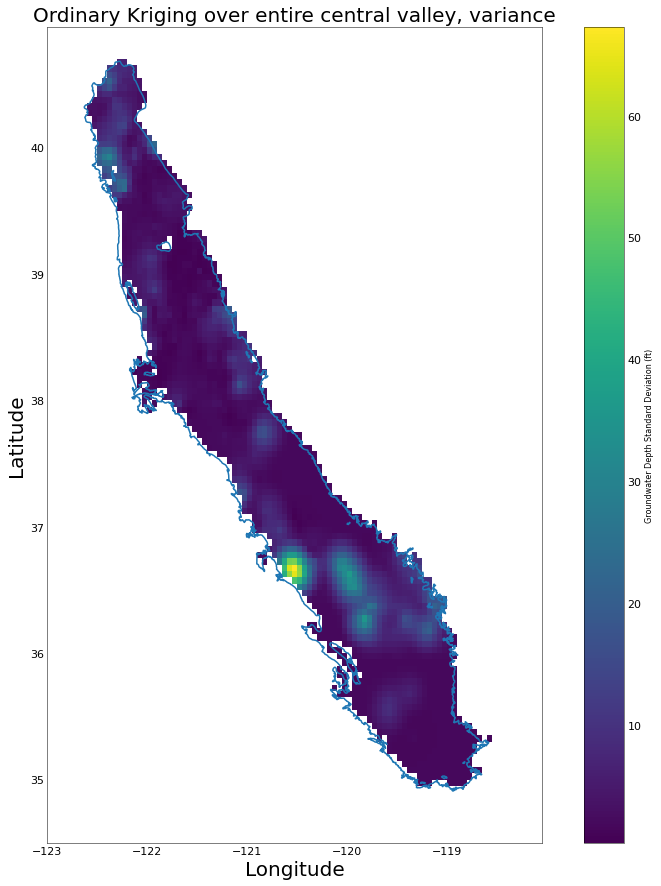

In [117]:
fig, ax = plt.subplots(figsize=(15,15))
#CA_map.boundary.plot(ax=ax, zorder=3)
CV_map.boundary.plot(ax=ax, zorder=4)
plt.pcolormesh(meshgridx, meshgridy, z_var, zorder=1)
plt.colorbar(label='Groundwater Depth Standard Deviation (ft)')
plt.pcolormesh(meshgridx, meshgridy, CV_overlay, cmap=new_binary, zorder=2)
plt.title('Ordinary Kriging over entire central valley, variance', fontsize=20)
plt.xlabel('Longitude', fontsize=20)
plt.ylabel('Latitude', fontsize=20)
#plt.savefig('OK_CV_only_vari.png', dpi=300)

piezometer at every well?

consider agricultural and residential wells in areas with not many observation wells

check quality control codes

worried about semiconfined (could be higher than the water table if pressurized) Need some method of confirming if a well is in an unconfined vs semiconfined zone (clay percent? well logs? insar?)

Christina thinks the answer could be in the well logs (line for depth of first water -> water level at level of confirmation)

DWR has some of those logs maybe? still a rangling effort